In [1]:
import os
import time
import matplotlib.pyplot as plt
import gc; gc.enable() # memory is tight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras

from skimage.segmentation import mark_boundaries
from skimage.util import montage as montage2d
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label
from typing import List
from google.cloud import bigquery, storage
from google.cloud import aiplatform as vertex_ai

import tensorflow as tf
from google_cloud_pipeline_components.experimental.custom_job import utils
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component

In [2]:
def rle_decode_tf(mask_rle, shape=(768, 768)):
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    # Reshape into mask
    return tf.expand_dims(tf.transpose(tf.reshape(mask_flat, shape)), axis=2)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T   # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    #in_mask_list = tf.compat.as_str_any(in_mask_list)
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [3]:
PROJECT = 'mle-airbus-detection-smu' # Change to your project id.
PROJECT_NUMBER = '484894607141'
REGION = 'asia-east1' # Change to your region.
BUCKET = 'mle_airbus_dataset' # Change to your bucket name.
SERVICE_ACCOUNT = "service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com"

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
!gcloud config set project {PROJECT}
    
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"

PIPELINE_NAME = 'airbusmlepipeline'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/{}/pipeline_root'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/{}/pipeline_module'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' data.
DATA_ROOT = 'gs://{}/{}/data'.format(BUCKET, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/{}/serving_model'.format(
    BUCKET, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))
print('MODULE_ROOT: {}'.format(MODULE_ROOT))
print('DATA_ROOT: {}'.format(DATA_ROOT))
print('SERVING_MODEL_DIR: {}'.format(SERVING_MODEL_DIR))

BQ_DATASET_NAME = 'mle-airbus-detection-smu.airbus_label_dataset' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'airbus_label'
BQ_LOCATION = ' asia-east1'
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

! gsutil ls -al "gs://"$BUCKET


storage_client = storage.Client(project=PROJECT)
bucket = storage_client.get_bucket(BUCKET)
storage_path = f"gs://{BUCKET}/train_v2/"
print (storage_path)

VERSION = 'v01'
DATASET_DISPLAY_NAME = 'airbus-ship-dataset-display'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

BATCH_SIZE = 16
EDGE_CROP = 0
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 10
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
N_SAMPLE = 1000
IMG_SHAPE = (768, 768)

Updated property [core/project].


PIPELINE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_root
MODULE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_module
DATA_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/data
SERVING_MODEL_DIR: gs://mle_airbus_dataset/airbusmlepipeline/serving_model
Project ID: mle-airbus-detection-smu
Region: asia-east1
Bucket name: mle_airbus_dataset
Service Account: service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com
Vertex API Parent URI: projects/mle-airbus-detection-smu/locations/asia-east1
gs://mle_airbus_dataset/train_v2/


In [4]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your GCP project id from gcloud
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].strip()
    print("Service Account:", SERVICE_ACCOUNT)

In [5]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator "gs://"$BUCKET

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer "gs://"$BUCKET

                                 gs://mle_airbus_dataset/pipeline_root/
                                 gs://mle_airbus_dataset/train_v2/
                                 gs://mle_airbus_dataset/trained_model/


No changes made to gs://mle_airbus_dataset/
No changes made to gs://mle_airbus_dataset/


# Setup Infra on GCP

In [6]:
import json
import os
import sys

import numpy as np
from google.cloud import aiplatform, bigquery
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

In [7]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

DEPLOY_GPU, DEPLOY_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

TRAIN_VERSION = "tf-gpu.2-8"
DEPLOY_VERSION = "tf2-gpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Training: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Train machine type n1-standard-4
Deploy machine type n1-standard-4


In [74]:
QUERY = "SELECT * FROM `mle-airbus-detection-smu.airbus_label_dataset.train`"

BQ_SOURCE_TRAIN = "bq://mle-airbus-detection-smu.airbus_label_dataset.train"
BQ_SOURCE_TEST = "bq://mle-airbus-detection-smu.airbus_label_dataset.test"

In [75]:
bqclient = bigquery.Client()

# Download a table.
table = bigquery.TableReference.from_string(
    "mle-airbus-detection-smu.airbus_label_dataset.label_data"
)
rows = bqclient.list_rows(
    table
)
df_train = rows.to_dataframe(
    # Optionally, explicitly request to use the BigQuery Storage API. As of
    # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
    # API is used by default.
    create_bqstorage_client=True,
)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


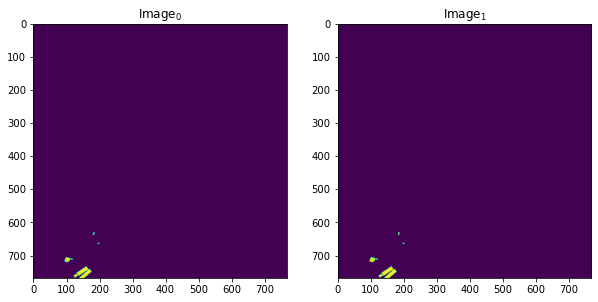

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'].values
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

In [76]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [71]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

162201 training masks
69522 validation masks


In [78]:
df_train.groupby('ImageId').max()

,EncodedPixels,ships,has_ship
ImageId,,,
0001124c7.jpg,0,1,1.0
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1.0
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5,1.0
00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9,1.0
0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2,1.0
...,...,...,...
fffe4fa23.jpg,0,1,1.0
fffe646cf.jpg,0,1,1.0
fffedbb6b.jpg,0,1,1.0


In [70]:
train_df = train_df.query("ImageId == '00fd8e126.jpg'").reset_index(drop=True)
train_df = pd.concat([train_df]*2000)
train_df

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
...,...,...,...,...,...
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]
0,00fd8e126.jpg,92737 2 93503 4 94269 7 95034 10 95800 13 9656...,1,1.0,[1.0]


<AxesSubplot:>

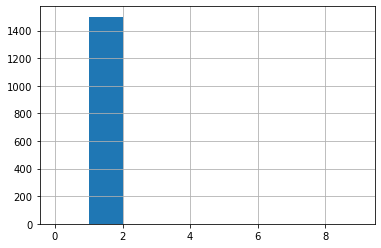

In [42]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [65]:
import numpy as np
from google.cloud import storage
from io import BytesIO
from PIL import Image

storage_path = f"gs://{BUCKET}/train_v2/"
local_path = r"D:\Data\train_v2\archive\\"


client = storage.Client() # Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

bucket = client.get_bucket('mle_airbus_dataset')

def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(local_path, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []
                
                
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (16, 768, 768, 3) 0.0 0.996078431372549
y (16, 768, 768, 1) 0 1500


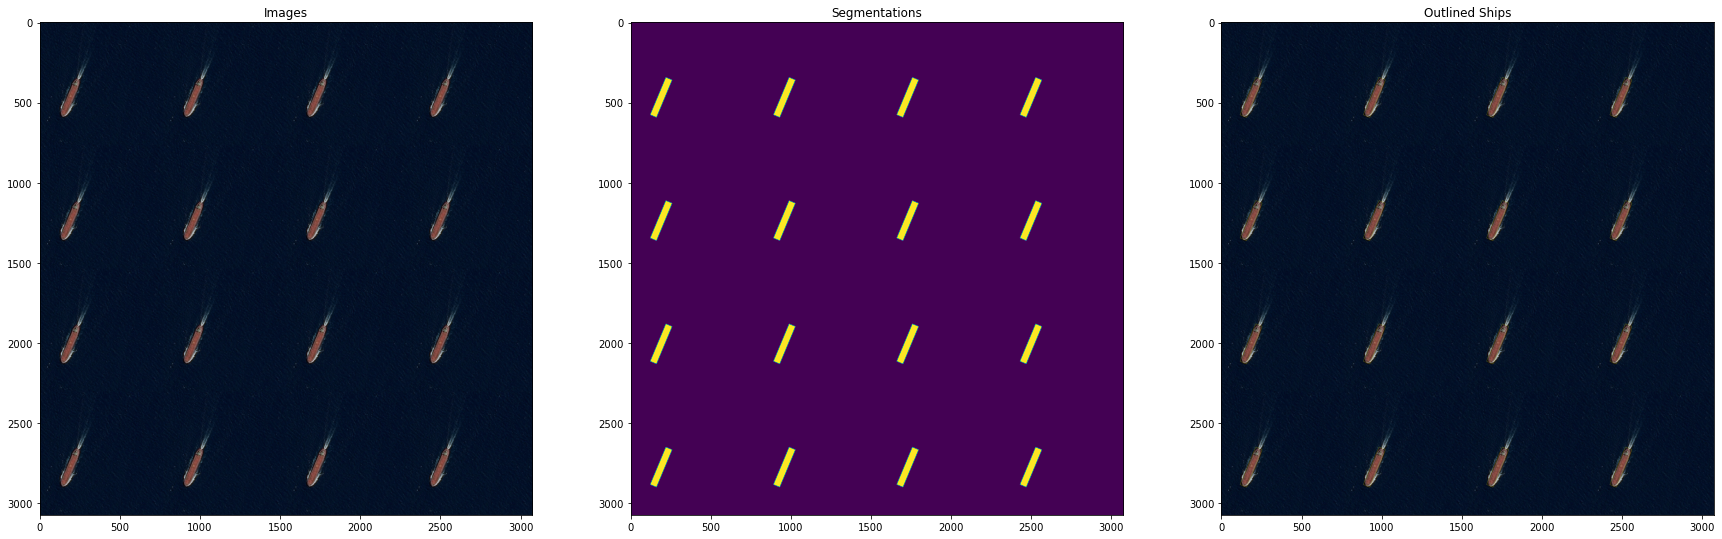

In [44]:
storage_path = f"gs://{BUCKET}/train_v2/"
local_path = r"D:\Data\train_v2\archive"

In [45]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)


def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (16, 768, 768, 3) float32 0.0 0.99210346
y (16, 768, 768, 1) float32 0.0 1500.0


Text(0.5, 1.0, 'ships')

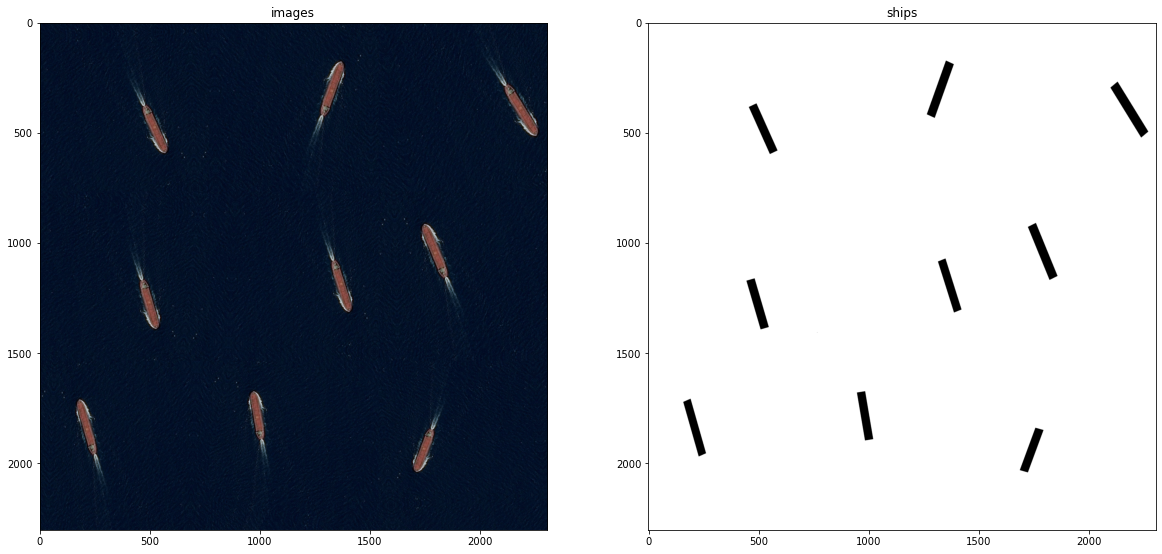

In [47]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [48]:
from src.models.u_net import UNet_keras
seg_model = UNet_keras(edge_crop=EDGE_CROP, upsample_mode=UPSAMPLE_MODE)

In [49]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) #- dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.ctph".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=50) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, reduceLROnPlat]

step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
NB_EPOCHS=5
loss_history = [seg_model.fit(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                              verbose=1,
                            workers=1 # the generator is not very thread safe
                                       )]

KeyboardInterrupt: 

In [ ]:
export_dir = './segm_kaggle_{}'.format(time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(seg_model, export_dir)

ValueError: too many values to unpack (expected 2)

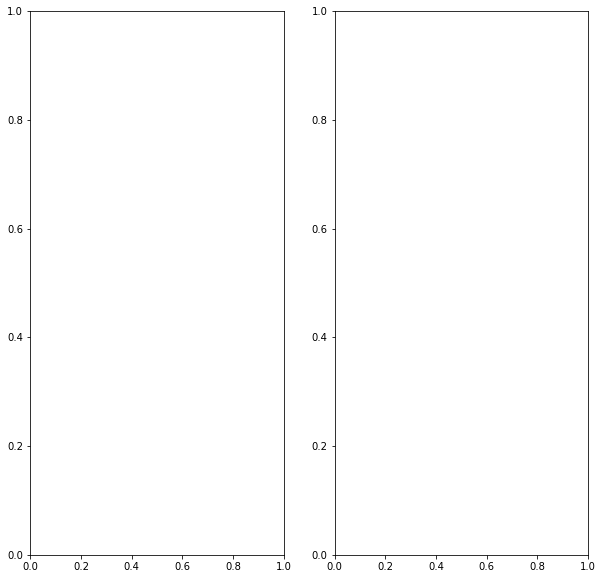

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for images, labels in next(train_gen):
    print (images, labels)
    img = images[0]
    lab = labels[0]
    ax[0] = ax[0].imshow(img)
    #ax[1] = ax[1].imshow(seg_model.predict(next(train_gen))[0])

In [66]:
x, y = next(train_gen)

In [58]:
x

(16, 768, 768, 3)